# Basic Imports

In [49]:
import os
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from constants import *
from rFmodel import *
from data_loader import *
from tqdm import tqdm
import PIL
import umap.plot

seed = 100
random.seed(seed)
np.random.seed(seed)

/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than o

# Loading Model

In [5]:
model_weights_path = "/tscc/nfs/home/vejoshi/vlm_comparison/ret_found_baseline_non_vlm/RETFound_MAE/experiments/\
test_oct/retFoundretFound_shape_224_unfreeze_50_lr_0.0005_poolType_avg.pt"

oct_model_weights = torch.load(model_weights_path, map_location = "cuda")
oct_model = build_model()
oct_model.load_state_dict(oct_model_weights, strict=False)
oct_model = oct_model.to("cuda")
oct_model.eval()

classificationModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(appro

# Loading Validation Data

In [8]:
og_df = pd.read_csv(dataset_csv)
val_df = og_df[og_df["Split"] == "val"]
print("Label distribution : ")
val_df["EyeDX_at_spectralisDate"].value_counts()

/tmp/ipykernel_432048/2208382707.py:1: DtypeWarning: Columns (11,41,43,44,45,46,55,96,126,435,436,437,438,439,444,445,452,453,462,471,480,481,490,491,498,499,504,505,506,507,508,509,510,511,512,513,518,519,526,527,536,545,554,555,564,565,572,573,578,579,580,581,582,624,653) have mixed types. Specify dtype option on import or set low_memory=False.
  og_df = pd.read_csv(dataset_csv)


Label distribution : 


EyeDX_at_spectralisDate
GVFD & GON    2489
Healthy       1086
GVFD          1020
Name: count, dtype: int64

# Add hooks to extract output

In [37]:
intermediate_outputs = {}

# Function to register forward hook
def get_intermediate_output(name):
    def hook(model, input, output):
        intermediate_outputs[name] = output
    return hook

# Register forward hooks for final feauture_vector....
oct_model.model.fc_norm.register_forward_hook(get_intermediate_output('final_feature_vector'))

# Pre_proc func

In [38]:
pre_proc_func = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# Extract Features

In [41]:
data_vec_list = []
mapping_dict = {"GVFD & GON" : 0,
                "Healthy" : 1,
                "GVFD" : 2}
with torch.set_grad_enabled(False):
    for img_path, lab in tqdm(zip(val_df["OCTImagePath"], val_df["EyeDX_at_spectralisDate"]), position = 0, leave = True):
        img_inp  = PIL.Image.open(img_path).convert('RGB').resize((input_shape[0],input_shape[1]))
        proc_img = torch.unsqueeze(pre_proc_func(img_inp),0).to("cuda")
        preds    = oct_model(proc_img)
        data_vec = intermediate_outputs["final_feature_vector"]
        data_vec_list.append(data_vec.detach().to("cpu").numpy())
data_vec_list = np.array(data_vec_list)
print("Computed : ",data_vec_list.shape)

4595it [02:53, 26.47it/s]

Computed :  (4595, 1, 1024)


# Visualising featues

In [59]:
data_vec_list = np.squeeze(data_vec_list)
mapper1 = umap.UMAP(n_neighbors = 100,
                    metric = 'euclidean').fit(data_vec_list)

<Axes: >

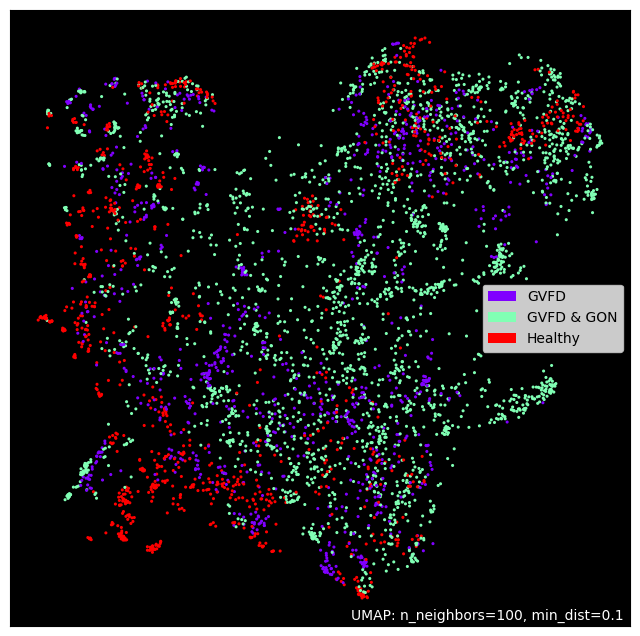

In [60]:
umap.plot.points(mapper1, 
                 labels = val_df["EyeDX_at_spectralisDate"], 
                 theme='fire')